In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking

from keras.callbacks import EarlyStopping

# map district name to district number
district_mapping_path = "../airflow/dags/data/districts.xlsx"

district_mapping = pd.read_excel(district_mapping_path)


def get_district_name(district_no):
    return district_mapping[district_mapping["Postal District"] == district_no][
        "General Location"
    ].values[0]

# Import Previous Files

In [64]:
# Import all previous files
# open pickle
train_df_dict = pd.read_pickle('data/train_df_dict.pkl')
train_df_dict_L = pd.read_pickle('data/train_df_dict_L.pkl')
test_df_dict = pd.read_pickle('data/test_df_dict.pkl')

# import resale_flat_transactions_clean
resale_flat_transactions_clean = pd.read_csv('data/resale_flat_transactions_clean.csv')

# import features 
all_district_var_ts = pd.read_pickle('data/all_district_var_ts.pkl')

# replace NaN values with 0 since we are using LSTM
# Mask layer will mask the 0 values
# merge the train set with the features
train_lstm_df_dict = {}
for district_no, district_df in train_df_dict.items():
    train_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    train_lstm_df_dict[district_no] = train_lstm_df_dict[district_no].fillna(0)

train_lstm_df_dict_L = {}
for district_no, district_df in train_df_dict_L.items():
    train_lstm_df_dict_L[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')

# merge the test set with the features
test_lstm_df_dict = {}
for district_no, district_df in test_df_dict.items():
    test_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    test_lstm_df_dict[district_no] = test_lstm_df_dict[district_no].fillna(0)

# Normalize the data
# create scalers for each district
scaler_dict = {}
for district_no, district_df in train_lstm_df_dict.items():
    scaler_dict[district_no] = MinMaxScaler(feature_range=(-1, 1))
    scaler_dict[district_no].fit(district_df)

# create scalers for each district
scaler_dict_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    scaler_dict_L[district_no] = MinMaxScaler(feature_range=(-1, 1))
    scaler_dict_L[district_no].fit(district_df)

# transform the train set
train_lstm_df_dict_scaled = {}
for district_no, district_df in train_lstm_df_dict.items():
    train_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the train set
train_lstm_df_dict_scaled_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    train_lstm_df_dict_scaled_L[district_no] = pd.DataFrame(
        scaler_dict_L[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the test set
test_lstm_df_dict_scaled = {}
for district_no, district_df in test_lstm_df_dict.items():
    test_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# Format Data for LSTM

In [79]:
# convert all data 

def create_dataset(df, lookback=3):
    X = []
    y = []
    for i in range(lookback, len(df)): 
        X.append(df[i - lookback : i, :])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2])) # (samples, timesteps, features)

    return X, y

# create dataset for each district
train_lstm_dataset_dict = {}
for district_no, district_df in train_lstm_df_dict_scaled.items():
    train_lstm_dataset_dict[district_no] = create_dataset(district_df.values)

# create dataset for each district
train_lstm_dataset_dict_L = {}
for district_no, district_df in train_lstm_df_dict_scaled_L.items():
    train_lstm_dataset_dict_L[district_no] = create_dataset(district_df.values)

# create dataset for each district
test_lstm_dataset_dict = {}
for district_no, district_df in test_lstm_df_dict_scaled.items():
    test_lstm_dataset_dict[district_no] = create_dataset(district_df.values)

    

# LSTM Model on Keras example on district 1

In [66]:
model = Sequential()
model.add(
    Masking(
        mask_value=0.,
        input_shape=(
            train_lstm_dataset_dict[1][0].shape[1], # timesteps
            train_lstm_dataset_dict[1][0].shape[2], # features
        ),
    )
)
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(
    train_lstm_dataset_dict[1][0], # X
    train_lstm_dataset_dict[1][1], # y
    epochs=100,
    batch_size=1,
    verbose=2,
)


Epoch 1/100


2023-04-02 21:09:56.293312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 21:09:56.558771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 21:09:56.766303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 - 3s - loss: 0.2783 - 3s/epoch - 71ms/step
Epoch 2/100
36/36 - 1s - loss: 0.2556 - 512ms/epoch - 14ms/step
Epoch 3/100
36/36 - 0s - loss: 0.2483 - 436ms/epoch - 12ms/step
Epoch 4/100
36/36 - 0s - loss: 0.2587 - 440ms/epoch - 12ms/step
Epoch 5/100
36/36 - 0s - loss: 0.2393 - 459ms/epoch - 13ms/step
Epoch 6/100
36/36 - 0s - loss: 0.2352 - 482ms/epoch - 13ms/step
Epoch 7/100
36/36 - 0s - loss: 0.2339 - 497ms/epoch - 14ms/step
Epoch 8/100
36/36 - 0s - loss: 0.2253 - 446ms/epoch - 12ms/step
Epoch 9/100
36/36 - 0s - loss: 0.2270 - 446ms/epoch - 12ms/step
Epoch 10/100
36/36 - 0s - loss: 0.2164 - 433ms/epoch - 12ms/step
Epoch 11/100
36/36 - 0s - loss: 0.2215 - 429ms/epoch - 12ms/step
Epoch 12/100
36/36 - 0s - loss: 0.2140 - 466ms/epoch - 13ms/step
Epoch 13/100
36/36 - 0s - loss: 0.2142 - 465ms/epoch - 13ms/step
Epoch 14/100
36/36 - 0s - loss: 0.2021 - 492ms/epoch - 14ms/step
Epoch 15/100
36/36 - 1s - loss: 0.2117 - 573ms/epoch - 16ms/step
Epoch 16/100
36/36 - 0s - loss: 0.1942 - 475ms/ep

## Get predictions and plot

In [82]:
# get the predictions
predictions = model.predict(test_lstm_dataset_dict[1][0])

# invert the predictions

predicted_padded = np.zeros((len(test_lstm_dataset_dict[1][0]), 9))
predicted_padded[:, 1] = predictions[:, 0]


predicted_padded = scaler_dict[1].inverse_transform(predicted_padded)


1/1 [==============================] - 0s 37ms/step


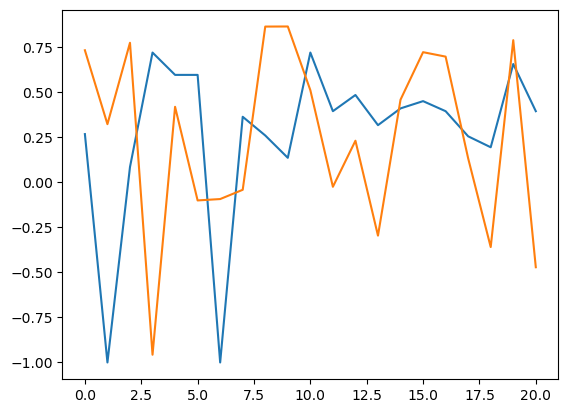

In [83]:
# visualise the predictions

plt.plot(test_lstm_dataset_dict[1][1])
plt.plot(predictions)
plt.show()


In [97]:
def evaluate_lstm(model, train_set, test_set):
    # make predictions
    train_predict = model.predict(train_set[0])
    test_predict = model.predict(test_set[0])
    # pad the predictions
    train_predict_padded = np.zeros((len(train_set[0]), 9))
    train_predict_padded[:, 1] = train_predict[:, 0]
    test_predict_padded = np.zeros((len(test_set[0]), 9))
    test_predict_padded[:, 1] = test_predict[:, 0]
    # invert the predictions
    train_predict_padded = scaler_dict[1].inverse_transform(train_predict_padded)
    test_predict_padded = scaler_dict[1].inverse_transform(test_predict_padded)
    # set the index of the predictions
    train_predict_padded = pd.DataFrame(
        train_predict_padded, index=train_set[1].index, columns=train_set[1].columns
    )
    test_predict_padded = pd.DataFrame(
        test_predict_padded, index=test_set[1].index, columns=test_set[1].columns
    )

    # calculate root mean squared error
    train_score = math.sqrt(mean_squared_error(train_set[1], train_predict_padded[:, 1]))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = math.sqrt(mean_squared_error(test_set[1], test_predict_padded[:, 1]))
    print('Test Score: %.2f RMSE' % (test_score))
    # plot baseline and predictions
    plt.plot(train_lstm_df_dict[1]['resale_price'], label="train_set")
    plt.plot(train_predict_padded[:, 1], label="train_predict")
    plt.plot(test_lstm_df_dict[1]['resale_price'], label="test_set")
    plt.plot(test_predict_padded[:, 1], label="test_predict")
    plt.legend()
    plt.show()
    


In [98]:
evaluate_lstm(model, train_lstm_dataset_dict[1], test_lstm_dataset_dict[1])

1/1 [==============================] - 0s 20ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'index'